# Inference Sandbox

### In this notebook, we'll mock up some data from the linear model, as reviewed [here](./LMreview4.ipynb). Then it's your job to implement a Metropolis sampler and constrain the posterior distriubtion. The goal is to play with various strategies for accelerating the convergence and acceptance rate of the chain. Remember to check the convergence and stationarity of your chains, and compare them to the known analytic posterior for this problem!

#### Generate a data set:

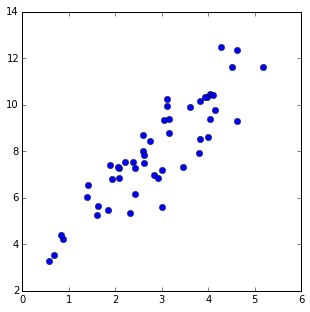

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0) 

# the model parameters
a = np.pi
b = 1.6818

# my arbitrary constants
mu_x = np.exp(1.0) # see definitions above
tau_x = 1.0
s = 1.0
N = 50 # number of data points

# get some x's and y's
x = mu_x + tau_x*np.random.randn(N)
y = a + b*x + s*np.random.randn(N)

plt.plot(x, y, 'o');

#### Package up a log-posterior function.

In [2]:
def lnPost(params, x, y):
    # This is written for clarity rather than numerical efficiency. Feel free to tweak it.
    a = params[0]
    b = params[1]
    lnp = 0.0
    # Using informative priors to achieve faster convergence is cheating in this exercise!
    # But this is where you would add them.
    lnp += -0.5*np.sum((a+b*x - y)**2)
    return lnp

#### Convenience functions encoding the exact posterior:

In [3]:
class ExactPosterior:
    def __init__(self, x, y, a0, b0):
        X = np.matrix(np.vstack([np.ones(len(x)), x]).T)
        Y = np.matrix(y).T
        self.invcov = X.T * X
        self.covariance = np.linalg.inv(self.invcov)
        self.mean = self.covariance * X.T * Y
        self.a_array = np.arange(0.0, 6.0, 0.02)
        self.b_array = np.arange(0.0, 3.25, 0.02)
        self.P_of_a = np.array([self.marg_a(a) for a in self.a_array])
        self.P_of_b = np.array([self.marg_b(b) for b in self.b_array])
        self.P_of_ab = np.array([[self.lnpost(a,b) for a in self.a_array] for b in self.b_array])
        self.P_of_ab = np.exp(self.P_of_ab)
        self.renorm = 1.0/np.sum(self.P_of_ab)
        self.P_of_ab = self.P_of_ab * self.renorm
        self.levels = scipy.stats.chi2.cdf(np.arange(1,4)**2, 1) # confidence levels corresponding to contours below
        self.contourLevels = self.renorm*np.exp(self.lnpost(a0,b0)-0.5*scipy.stats.chi2.ppf(self.levels, 2))
    def lnpost(self, a, b): # the 2D posterior
        z = self.mean - np.matrix([[a],[b]])
        return -0.5 * (z.T * self.invcov * z)[0,0]
    def marg_a(self, a): # marginal posterior of a
        return scipy.stats.norm.pdf(a, self.mean[0,0], np.sqrt(self.covariance[0,0]))
    def marg_b(self, b): # marginal posterior of b
        return scipy.stats.norm.pdf(b, self.mean[1,0], np.sqrt(self.covariance[1,1]))
exact = ExactPosterior(x, y, a, b)

#### Demo some plots of the exact posterior distribution

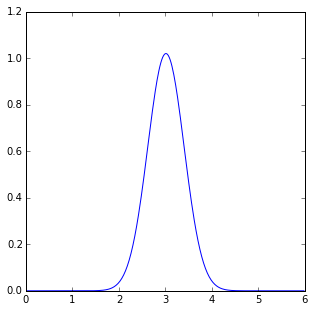

In [4]:
plt.plot(exact.a_array, exact.P_of_a);

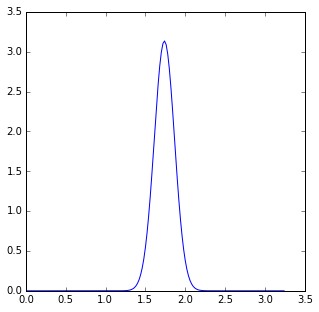

In [5]:
plt.plot(exact.b_array, exact.P_of_b);

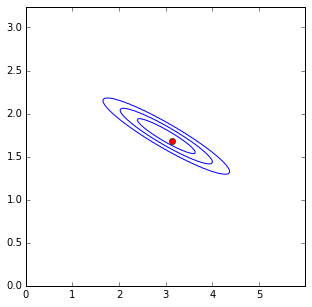

In [6]:
plt.contour(exact.a_array, exact.b_array, exact.P_of_ab, colors='blue', levels=exact.contourLevels);
plt.plot(a, b, 'o', color='red');

### Ok, you're almost ready to go! A decidely minimal stub of a Metropolis loop appears below; of course, you don't need to stick exactly with this layout. Once again, after running a chain, be sure to
1. visually inspect traces of each parameter to see whether they appear converged  
2. compare the marginal and joint posterior distributions to the exact solution to check whether they've converged to the correct distribution
> Normally, you should always use quantitative tests of convergence *in addition to* visual inspection, as you saw on Tuesday. For this class (only), let's save some time by relying only on visual impressions and comparison to the exact posterior.

(see the snippets farther down)

### If you think you have a sampler that works well, use it to run some more chains from different starting points and compare them both visually and using the numerical convergence criteria covered in class.

### Once you have a working sampler, the question is: how can we make it converge faster? Experiment! We'll compare notes in a bit.

In [153]:
Nsamples = 4242 # fill in a number
samples = np.zeros((Nsamples, 2))
# put any more global definitions here
step_size = 0.084*2
a_current = 2.42;
b_current = 0.42;
lnp_current = lnPost([a_current,b_current], x, y);
Naccept = 0;

def lnPost_alt(params, x, y):
    # This is written for clarity rather than numerical efficiency. Feel free to tweak it.
    a = params[0]
    b = params[1]
    lnp = 0.0
    # Using informative priors to achieve faster convergence is cheating in this exercise!
    # But this is where you would add them.
    lnp += -0.5*np.sum((a+b*(x-np.mean(x)) - y)**2)
    return lnp

def proposal(a_current, b_current):
    return a_current+np.random.uniform(-step_size,step_size),b_current+np.random.uniform(-step_size,step_size);
    #return a_current+np.random.uniform(-step_size,step_size),b_current+np.random.uniform(-step_size,step_size);
    
def we_accept_this_proposal(lnp_try, lnp_current):
    return (np.exp(lnp_try - lnp_current) > np.random.uniform())
    
for i in range(Nsamples):
    a_try, b_try = proposal(a_current, b_current) # propose new parameter value(s)
    samples[i] = a_try,b_try;
    lnp_try = lnPost([a_try,b_try], x, y) # calculate posterior density for the proposal
    if we_accept_this_proposal(lnp_try, lnp_current):
        # do something
        a_current = a_try;
        b_current = b_try;
        lnp_current = lnPost([a_current,b_current], x, y);
        Naccept += 1;
    else:
        # do something else
        pass;

In [154]:
Naccept/Nsamples

0.40641206977840644

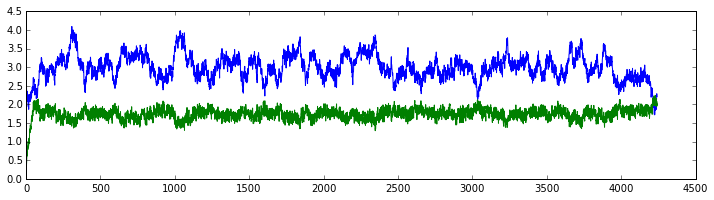

In [155]:
plt.rcParams['figure.figsize'] = (12.0, 3.0)
plt.plot(samples[:,0]);
plt.plot(samples[:,1]);

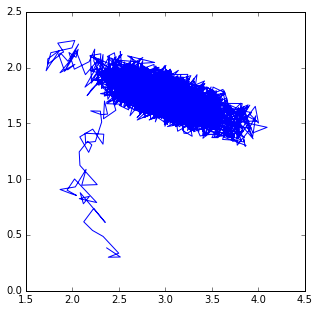

In [156]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.plot(samples[:,0], samples[:,1]);

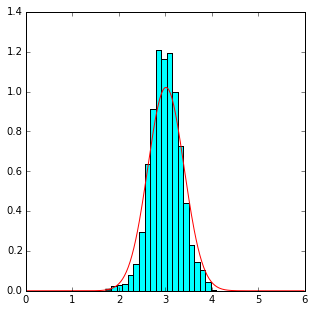

In [157]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.hist(samples[:,0], 20, normed=True, color='cyan');
plt.plot(exact.a_array, exact.P_of_a, color='red');

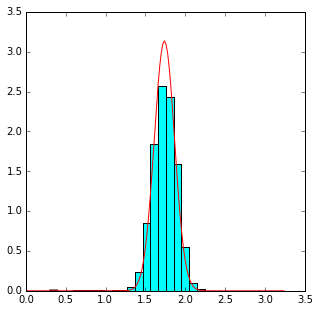

In [158]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.hist(samples[:,1], 20, normed=True, color='cyan');
plt.plot(exact.b_array, exact.P_of_b, color='red');

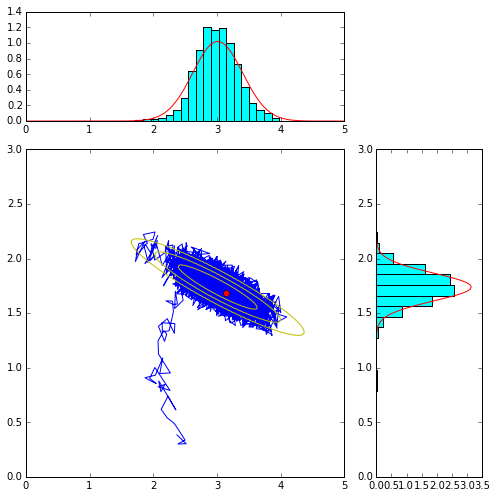

In [159]:
# If you know how to easily overlay the 2D sample and theoretical confidence regions, by all means do so.
from matplotlib import gridspec
fig = plt.figure(figsize=(7,7))
gs = gridspec.GridSpec(2,2,width_ratios=[3,1],height_ratios=[1,3]);
plt.subplot(gs[0])
plt.hist(samples[:,0], 20, normed=True, color='cyan');
plt.plot(exact.a_array, exact.P_of_a, color='red');
plt.xlim((0,5));
plt.subplot(gs[2])
plt.plot(samples[:,0], samples[:,1]);
plt.contour(exact.a_array, exact.b_array, exact.P_of_ab, colors='y', levels=exact.contourLevels, zorder=3);
plt.plot(a, b, 'o', color='red');
plt.xlim((0,5));
plt.ylim((0,3));
plt.subplot(gs[3])
plt.hist(samples[:,1], 20, normed=True, orientation='horizontal', color='cyan');
plt.plot(exact.P_of_b, exact.b_array, color='red');
plt.ylim((0,3));
plt.tight_layout();

In [160]:
lnp_current

-27.820345431740865

In [161]:
lnp_try

-27.820345431740865